In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from dataloaders import *
import pandas as pd
from models import VAE

In [2]:
dataset_name = 'boston'
batch_size = 1
name = 'vae'

(var_info, (train_loader, val_loader, test_loader)) = load_dataset(dataset_name, batch_size=batch_size, shuffle=True, seed=42)
data_loader = test_loader
D = len(var_info.keys()) # total number of variables in data
L = D  # number of latents (later 2x, i.e. mu and sigma per variable, i.e. output dim of encoder)
M = 256
# total of the number of values per variable (i.e. output dim of decoder)

total_num_vals = 0
for var in var_info.keys():
    total_num_vals += var_info[var]['num_vals']


prior = torch.distributions.MultivariateNormal(torch.zeros(L), torch.eye(L))
model = VAE(total_num_vals=total_num_vals, L=L, var_info = var_info, D=D, M=M)


model.load_state_dict(torch.load('results/vae.model'))
model.eval()

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=14, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=28, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=14, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=28, bias=True)
    )
  )
  (prior): Prior()
)

Generate a sample

In [73]:
# check samples_generated from utils.py
x = next(iter(data_loader)).detach().numpy()
# GENERATIONS-------
n_samples = 50 # (batch size)
x = model.sample(n_samples) # p(x|z)
# x = np.array([x[0] for x in x])
x = x.detach().numpy()

In [74]:
names = []
for key, var in var_info.items():
    names.append(var['name'])
df = pd.DataFrame(x, columns = names)

In [75]:
len(data_loader)

79

In [76]:
n_test_points = 50
test_points = np.zeros((n_test_points, 14))
# test_loader = iter(test_loader)
for i, datapoint in enumerate(data_loader):
    if i == n_test_points:
        break
    test_points[i,:] = datapoint.detach().numpy()
df = pd.concat([df, pd.DataFrame(test_points, columns = names)]).reset_index(drop=True)

In [77]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.169006,0.861388,-0.066990,0.0,-0.162831,0.743663,0.064836,-0.594197,0.049120,0.487946,0.625836,0.237396,1.135134,1.018152
1,-0.484167,0.485691,-0.079707,0.0,-0.041849,1.247397,0.487560,-0.103991,-0.457393,0.579866,0.564216,-0.115910,0.829863,0.127822
2,0.597788,0.012289,0.522575,0.0,0.935153,0.625270,0.171713,0.388705,0.011499,0.610145,-0.087238,-0.232550,1.176371,0.315071
3,0.942110,-0.223300,0.352576,0.0,0.422089,0.021060,0.501281,0.521448,0.213490,1.397384,-0.037190,-0.052241,-0.595181,0.598062
4,0.199354,0.992081,0.634865,0.0,1.337981,0.623479,0.908924,0.565284,0.002524,0.523791,0.979010,0.575874,0.694928,0.296823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.002861,0.000000,0.274035,0.0,0.271784,0.455853,0.909372,0.128131,0.173913,0.375954,0.877778,0.985620,0.381347,0.320000
96,0.000129,0.850000,-0.021953,0.0,0.043568,0.489427,0.337796,0.732572,0.043478,0.240458,0.477778,1.000000,0.111479,0.437778
97,0.321992,0.000000,0.635125,0.0,0.431535,0.221714,1.000000,0.041167,1.000000,0.914122,0.800000,0.528455,0.506347,0.251111
98,0.003720,0.000000,0.778577,0.0,0.487552,0.505777,0.988671,0.089313,0.130435,0.477099,0.911111,0.995283,0.299945,0.315556


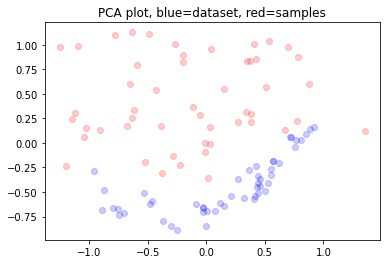

In [78]:
def pcaplot(df):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(df)
    X_pca = pca.transform(df)
    plt.scatter(X_pca[0:n_samples, 0], X_pca[0:n_samples, 1], alpha=0.2, color='red')
    plt.scatter(X_pca[n_samples:, 0], X_pca[n_samples:, 1], alpha=0.2, color='blue')
    plt.title('PCA plot, blue=dataset, red=samples')
    plt.show()
pcaplot(df)